<a href="https://colab.research.google.com/github/merles/Deep-Learning/blob/master/logistic_cat_in_dat_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sin, cos, pi
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import string
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer

In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = './drive/My\ Drive/Colab\ Notebooks/cat_in_dat_ii/input/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = './drive/My Drive/Colab Notebooks/cat_in_dat_ii/input/'
!ls ./drive/My\ Drive/Colab\ Notebooks/cat_in_dat_ii/input/

sample_submission.csv  test.csv  train.csv


In [0]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
train_idx = train['id']
test_idx = test['id']
df = train.append(test)

First lets get rid of the missing values NaN, the most frequent value will be used as the filler. 

Let's create a function that will fill the na in the tabular data. We will impute missing values with the median/most frequent value and create a new column indicating the na was missing. Also a function to create one hot encoding vectors for the multiclass cateogries. Finally a helper funciton to transform all the strings to ints so we can apply the categorify function.

In [0]:
def fill_na(df, fillna_names):
  for col in fillna_names:
    if df[col].isna().sum():
      filler = df[col].mode()[0]
      print(f'in column: {col} filler is {filler}')
      df[col+'_was_na'] = df[col].isna().astype(int)
      df[col]= df[col].fillna(filler)



In [0]:
fill_na(train, train.columns)
fill_na(test, test.columns)


in column: bin_0 filler is 0.0
in column: bin_1 filler is 0.0
in column: bin_2 filler is 0.0
in column: bin_3 filler is F
in column: bin_4 filler is N
in column: nom_0 filler is Red
in column: nom_1 filler is Triangle
in column: nom_2 filler is Hamster
in column: nom_3 filler is India
in column: nom_4 filler is Theremin
in column: nom_5 filler is fc8fc7e56
in column: nom_6 filler is ea8c5e181
in column: nom_7 filler is 4ae48e857
in column: nom_8 filler is 7d7c02c57
in column: nom_9 filler is 8f3276a6e
in column: ord_0 filler is 1.0
in column: ord_1 filler is Novice
in column: ord_2 filler is Freezing
in column: ord_3 filler is n
in column: ord_4 filler is N
in column: ord_5 filler is Fl
in column: day filler is 3.0
in column: month filler is 8.0
in column: bin_0 filler is 0.0
in column: bin_1 filler is 0.0
in column: bin_2 filler is 0.0
in column: bin_3 filler is F
in column: bin_4 filler is N
in column: nom_0 filler is Red
in column: nom_1 filler is Triangle
in column: nom_2 filler is

In [0]:
print(f'number of Nan elements in train:{train.isna().sum().sum()}')
print(f'number of Nan elements in test:{test.isna().sum().sum()}')

number of Nan elements in train:0
number of Nan elements in test:0


There are no missing values, next step is convert all nominal features to int values so we can convert to one-hot-encoding vectors.
Let's create a dictionary to convert all strings to ints.

In [0]:
cat_names = ['bin_3', 'bin_4','nom_0','nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
d_nom ={name: {item : i for i,item in enumerate(set(list(train[name].unique())+list(test[name].unique())))} for name in cat_names}

in the var d_nom there are all the dictionaries for the columns cat_names. Now we map this dictionaries to get the int values

In [0]:
for c in cat_names: train[c] = train[c].map(d_nom[c])
for c in cat_names: test[c] = test[c].map(d_nom[c])

In [0]:
print(f'number of Nan elements in train:{train.isna().sum().sum()}')
print(f'number of Nan elements in test:{test.isna().sum().sum()}')

number of Nan elements in train:0
number of Nan elements in test:0


In [0]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,bin_0_was_na,bin_1_was_na,bin_2_was_na,bin_3_was_na,bin_4_was_na,nom_0_was_na,nom_1_was_na,nom_2_was_na,nom_3_was_na,nom_4_was_na,nom_5_was_na,nom_6_was_na,nom_7_was_na,nom_8_was_na,nom_9_was_na,ord_0_was_na,ord_1_was_na,ord_2_was_na,ord_3_was_na,ord_4_was_na,ord_5_was_na,day_was_na,month_was_na
0,0,0.0,0.0,0.0,0,1,2,1,5,1,1,231,1497,140,36,412,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1.0,1.0,0.0,0,0,2,3,1,2,3,199,174,80,105,1774,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0.0,1.0,0.0,0,1,2,2,5,5,1,429,1433,180,152,1142,3.0,Novice,Freezing,n,P,eN,5.0,9.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
3,3,0.0,0.0,0.0,0,1,2,5,5,4,3,434,1244,167,151,246,1.0,Novice,Lava Hot,a,C,Fl,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,0.0,0.0,0.0,1,1,2,2,5,3,3,257,1100,163,139,1456,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


Next step is to tackle the oridnals, we will define a dictionary for each of them except for ord_5


In [0]:
print(train['ord_1'].unique())
print(train['ord_2'].unique())

['Contributor' 'Grandmaster' 'Novice' 'Expert' 'Master']
['Hot' 'Warm' 'Freezing' 'Lava Hot' 'Cold' 'Boiling Hot']


In [0]:
d_ord_1 = {'Contributor':0, 'Grandmaster':4, 'Novice':1, 'Expert':2, 'Master':3}
d_ord_2 = {'Hot':3, 'Warm':2, 'Freezing':0, 'Lava Hot':5, 'Cold':1, 'Boiling Hot':4}


In [0]:
dict_letters = {char:n for n,char in enumerate(string.ascii_letters)}
d_ord_3 = dict_letters
d_ord_4 = dict_letters

In [0]:
print(dict_letters)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51}


In [0]:
len(dict_letters)

52

In [0]:
def str_to_ord(ord_5):
  return dict_letters[ord_5[0]]*len(dict_letters) + dict_letters[ord_5[1]]


In [0]:
d_ord = [d_ord_1, d_ord_2, d_ord_3, d_ord_4]
ord = ['ord_1', 'ord_2', 'ord_3', 'ord_4']
for c, d in zip(ord,d_ord): train[c] = train[c].map(d)
for c, d in zip(ord,d_ord): test[c] = test[c].map(d)


In [0]:
train['ord_5'] = train['ord_5'].apply(str_to_ord)

In [0]:
test['ord_5'] = test['ord_5'].apply(str_to_ord)

In [0]:
print(f'number of Nan elements in train:{train.isna().sum().sum()}')
print(f'number of Nan elements in test:{test.isna().sum().sum()}')

number of Nan elements in train:0
number of Nan elements in test:0


Day and Month represent cyclic features, in order to represent this behaviour we will add 2 columns for each one, sin and cos as if the values where placed around a cirlce

In [0]:
train['sin_day'] = train['day'].apply(lambda x : sin(x*2*pi/7))
test['sin_day'] = test['day'].apply(lambda x : sin(x*2*pi/7))
train['cos_day'] = train['day'].apply(lambda x : cos(x*2*pi/7))
test['cos_day'] = test['day'].apply(lambda x : cos(x*2*pi/7))

train['sin_month'] = train['month'].apply(lambda x : sin(x*2*pi/12))
test['sin_month'] = test['month'].apply(lambda x : sin(x*2*pi/12))
train['cos_month'] = train['month'].apply(lambda x : cos(x*2*pi/12))
test['cos_month'] = test['month'].apply(lambda x : cos(x*2*pi/12))

Let's get rid of the columns that are not going to be used: id, day and month. Notice month_was_na and day_was_na to keep information about imputed values

In [0]:
train.drop(columns=['day','month','id'],inplace=True)
test.drop(columns=['day','month','id'],inplace=True)

In [0]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
train.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'target', 'bin_0_was_na',
       'bin_1_was_na', 'bin_2_was_na', 'bin_3_was_na', 'bin_4_was_na',
       'nom_0_was_na', 'nom_1_was_na', 'nom_2_was_na', 'nom_3_was_na',
       'nom_4_was_na', 'nom_5_was_na', 'nom_6_was_na', 'nom_7_was_na',
       'nom_8_was_na', 'nom_9_was_na', 'ord_0_was_na', 'ord_1_was_na',
       'ord_2_was_na', 'ord_3_was_na', 'ord_4_was_na', 'ord_5_was_na',
       'day_was_na', 'month_was_na', 'sin_day', 'cos_day', 'sin_month',
       'cos_month'],
      dtype='object')

## MODEL

Let's create a keras model 

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.backend.clear_session()
from sklearn.preprocessing import StandardScaler

from tensorflow import feature_column

In [0]:
train_ds = df_to_dataset(train[:-5000],shuffle=True,batch_size=10000)
val_ds = df_to_dataset(train[-5000:],shuffle=False,batch_size=10000)

In [0]:
print(train_ds)

<BatchDataset shapes: ({bin_0: (None,), bin_1: (None,), bin_2: (None,), bin_3: (None,), bin_4: (None,), nom_0: (None,), nom_1: (None,), nom_2: (None,), nom_3: (None,), nom_4: (None,), nom_5: (None,), nom_6: (None,), nom_7: (None,), nom_8: (None,), nom_9: (None,), ord_0: (None,), ord_1: (None,), ord_2: (None,), ord_3: (None,), ord_4: (None,), ord_5: (None,), bin_0_was_na: (None,), bin_1_was_na: (None,), bin_2_was_na: (None,), bin_3_was_na: (None,), bin_4_was_na: (None,), nom_0_was_na: (None,), nom_1_was_na: (None,), nom_2_was_na: (None,), nom_3_was_na: (None,), nom_4_was_na: (None,), nom_5_was_na: (None,), nom_6_was_na: (None,), nom_7_was_na: (None,), nom_8_was_na: (None,), nom_9_was_na: (None,), ord_0_was_na: (None,), ord_1_was_na: (None,), ord_2_was_na: (None,), ord_3_was_na: (None,), ord_4_was_na: (None,), ord_5_was_na: (None,), day_was_na: (None,), month_was_na: (None,), sin_day: (None,), cos_day: (None,), sin_month: (None,), cos_month: (None,)}, (None,)), types: ({bin_0: tf.float64

In [0]:
feature_columns = []

for c in ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5',
       'bin_0_was_na', 'bin_1_was_na', 'bin_2_was_na', 'bin_3_was_na',
       'bin_4_was_na', 'nom_0_was_na', 'nom_1_was_na', 'nom_2_was_na',
       'nom_3_was_na', 'nom_4_was_na', 'nom_5_was_na', 'nom_6_was_na',
       'nom_7_was_na', 'nom_8_was_na', 'nom_9_was_na', 'ord_0_was_na',
       'ord_1_was_na', 'ord_2_was_na', 'ord_3_was_na', 'ord_4_was_na',
       'ord_5_was_na', 'day_was_na', 'month_was_na', 'sin_day', 'cos_day',
       'sin_month', 'cos_month']:
  feature_columns.append(feature_column.numeric_column(c))
for c in ['nom_0','nom_1','nom_2','nom_3', 'nom_4']:
  col = feature_column.categorical_column_with_identity(c,train[c].nunique(),)
  col_oh = feature_column.indicator_column(col)
  feature_columns.append(col_oh)

for c in 'nom_5','nom_6','nom_7','nom_8','nom_9':
  column = feature_column.categorical_column_with_identity(c,train[c].nunique())
  feature_columns.append(feature_column.embedding_column(column,25))

In [0]:
feature_layer = layers.DenseFeatures(feature_columns,)
train_ds


<BatchDataset shapes: ({bin_0: (None,), bin_1: (None,), bin_2: (None,), bin_3: (None,), bin_4: (None,), nom_0: (None,), nom_1: (None,), nom_2: (None,), nom_3: (None,), nom_4: (None,), nom_5: (None,), nom_6: (None,), nom_7: (None,), nom_8: (None,), nom_9: (None,), ord_0: (None,), ord_1: (None,), ord_2: (None,), ord_3: (None,), ord_4: (None,), ord_5: (None,), bin_0_was_na: (None,), bin_1_was_na: (None,), bin_2_was_na: (None,), bin_3_was_na: (None,), bin_4_was_na: (None,), nom_0_was_na: (None,), nom_1_was_na: (None,), nom_2_was_na: (None,), nom_3_was_na: (None,), nom_4_was_na: (None,), nom_5_was_na: (None,), nom_6_was_na: (None,), nom_7_was_na: (None,), nom_8_was_na: (None,), nom_9_was_na: (None,), ord_0_was_na: (None,), ord_1_was_na: (None,), ord_2_was_na: (None,), ord_3_was_na: (None,), ord_4_was_na: (None,), ord_5_was_na: (None,), day_was_na: (None,), month_was_na: (None,), sin_day: (None,), cos_day: (None,), sin_month: (None,), cos_month: (None,)}, (None,)), types: ({bin_0: tf.float64

In [0]:
positives = train['target'].sum()
negatives = len(train['target'])- positives
bias_final = np.log(positives/negatives)
print(bias_final)
total = positives + negatives
weight_for_0 = (1 / negatives)*(total)/2.0 
weight_for_1 = (1 / positives)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}


-1.468274652141982


In [0]:
model = tf.keras.Sequential([
  feature_layer,
  layers.BatchNormalization(),
  layers.Dropout(0.04),
  layers.Dense(512),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.Dropout(0.2),
  layers.Dense(256),
  layers.Activation('relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Dense(1,activation = 'sigmoid')
])
METRICS = [
      keras.metrics.AUC(name='auc'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      
]




In [0]:
model.compile(optimizer=keras.optimizers.Adam(0.0003),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)


In [0]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=2,
    patience=3,
    mode='max',
    restore_best_weights=True)


In [0]:

history = model.fit(train_ds,
            validation_data = val_ds,
            epochs = EPOCHS,
            batch_size = BATCH_SIZE, 
            class_weight=class_weight,
            callbacks=[early_stopping])

Epoch 1/100
60/60 [==============================] - 24s 398ms/step - loss: 0.6869 - auc: 0.6923 - fp: 201436.0000 - fn: 34636.0000 - accuracy: 0.6032 - precision: 0.2760 - recall: 0.6892 - val_loss: 1.0653 - val_auc: 0.7144 - val_fp: 3820.0000 - val_fn: 10.0000 - val_accuracy: 0.2340 - val_precision: 0.1884 - val_recall: 0.9889
Epoch 2/100
60/60 [==============================] - 23s 375ms/step - loss: 0.6647 - auc: 0.7391 - fp: 167475.0000 - fn: 33161.0000 - accuracy: 0.6628 - precision: 0.3185 - recall: 0.7024 - val_loss: 0.9438 - val_auc: 0.7280 - val_fp: 2551.0000 - val_fn: 94.0000 - val_accuracy: 0.4710 - val_precision: 0.2394 - val_recall: 0.8952
Epoch 3/100
60/60 [==============================] - 23s 375ms/step - loss: 0.6547 - auc: 0.7450 - fp: 128648.0000 - fn: 41449.0000 - accuracy: 0.7141 - precision: 0.3523 - recall: 0.6280 - val_loss: 0.8538 - val_auc: 0.7361 - val_fp: 1614.0000 - val_fn: 237.0000 - val_accuracy: 0.6298 - val_precision: 0.2902 - val_recall: 0.7358
Epoch 

In [0]:
submission = pd.read_csv(path + 'sample_submission.csv')

In [0]:
y = model.predict(dict(test),batch_size=2048)

In [0]:
submission['target'] = y
submission.to_csv('submission.csv',index = False)

In [0]:
 emb_input = tf.keras.Input(shape=(10,),dtype='int32', name='emb_input')
X = layers.Embedding(2218,64)(emb_input)
X = layers.BatchNormalization()(X)
X = layers.Dropout(rate = 0.2)(X)
X = layers.Reshape((640,))(X)
num_input = tf.keras.Input(shape = (39,), dtype='float64', name = 'num_input')
concat_layer = layers.concatenate([X,num_input])
X = layers.Dense(600,activation='relu')(concat_layer)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.2)(X)
X = layers.Dense(100,activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.2)(X)
output = layers.Dense(1,activation='sigmoid')(X)
model = keras.Model(inputs= [emb_input,num_input], outputs= output)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



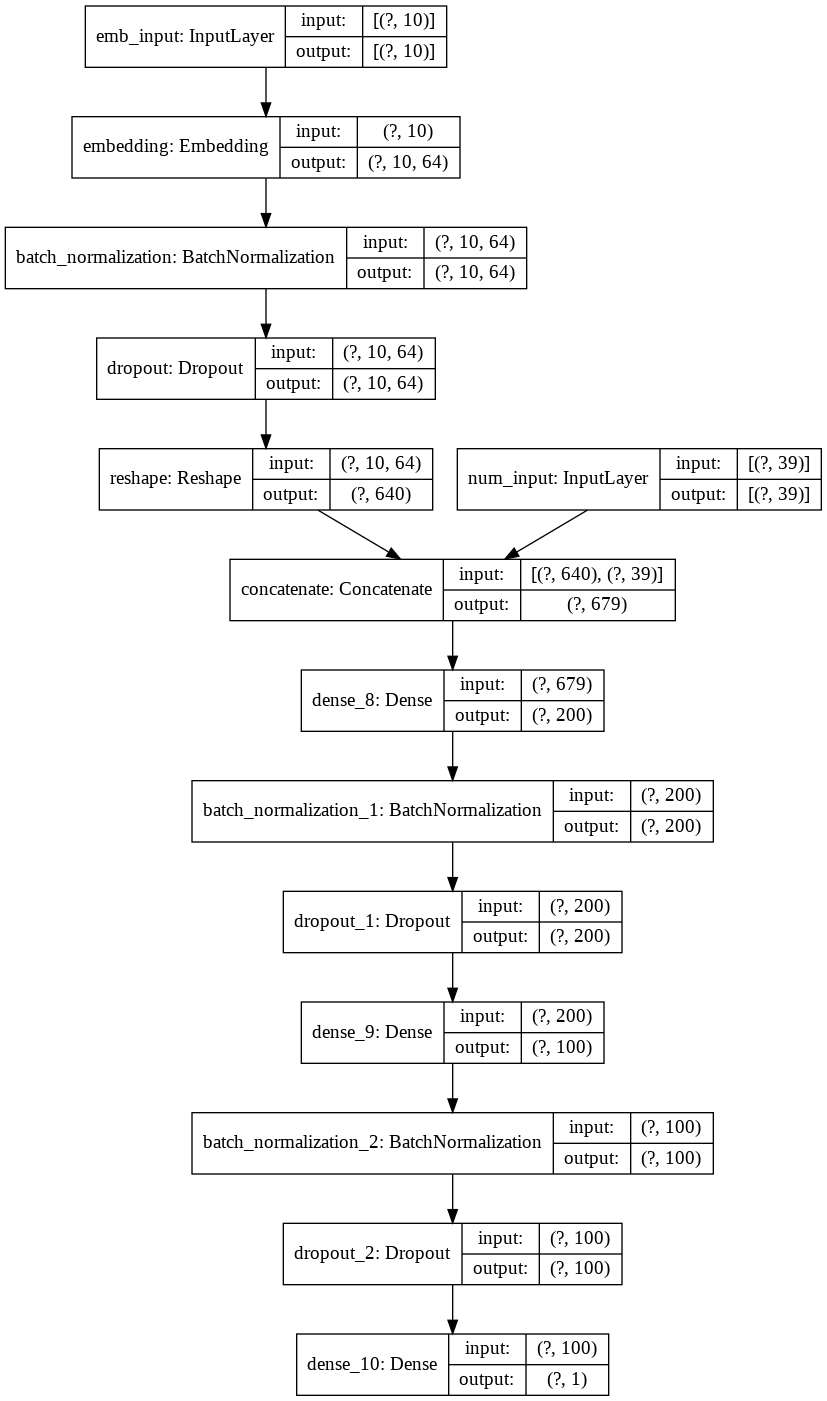

In [0]:
keras.utils.plot_model(model,show_layer_names=True, show_shapes=True)

In [0]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 64)       141952      emb_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 64)       256         embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10, 64)       0           batch_normalization[0][0]        
____________________________________________________________________________________________

let's compile de model

In [0]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = [keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.AUC(name='auc')])

In [0]:
scaler = StandardScaler()


In [0]:
X_embed = train[['nom_0','nom_1','nom_2','nom_3', 'nom_4','nom_5','nom_6','nom_7','nom_8', 'nom_9']].to_numpy()
X_num = train.drop(columns=['nom_0','nom_1','nom_2','nom_3', 'nom_4','nom_5','nom_6','nom_7','nom_8', 'nom_9', 'target']).to_numpy()

In [0]:
target = train['target'].to_numpy()

In [0]:
X_embed.shape, X_num.shape

((600000, 10), (600000, 39))

In [0]:
history = model.fit({'emb_input': X_embed, 'num_input': X_num, },target,
          epochs=50,
          batch_size=50000,
          validation_split = 0.02)
print('\nhistory dict:', history.history)


Epoch 1/50
12/12 [==============================] - 2s 155ms/step - loss: 0.5322 - accuracy: 0.7941 - auc: 0.5098 - val_loss: 0.4950 - val_accuracy: 0.8158 - val_auc: 0.5459
Epoch 2/50
12/12 [==============================] - 2s 152ms/step - loss: 0.5150 - accuracy: 0.8034 - auc: 0.5139 - val_loss: 0.4770 - val_accuracy: 0.8158 - val_auc: 0.5487
Epoch 3/50
12/12 [==============================] - 2s 151ms/step - loss: 0.5042 - accuracy: 0.8081 - auc: 0.5130 - val_loss: 0.4866 - val_accuracy: 0.8158 - val_auc: 0.5447
Epoch 4/50
12/12 [==============================] - 2s 152ms/step - loss: 0.4983 - accuracy: 0.8103 - auc: 0.5161 - val_loss: 0.4772 - val_accuracy: 0.8158 - val_auc: 0.5494
Epoch 5/50
12/12 [==============================] - 2s 154ms/step - loss: 0.4951 - accuracy: 0.8113 - auc: 0.5190 - val_loss: 0.4787 - val_accuracy: 0.8158 - val_auc: 0.5385
Epoch 6/50
12/12 [==============================] - 2s 150ms/step - loss: 0.4937 - accuracy: 0.8118 - auc: 0.5168 - val_loss: 0.53

In [0]:
entrada = scaler.fit_transform(X_num)

In [0]:
input_simple = keras.Input(shape=(39,))
X = layers.Dense(39,activation='relu')(input_simple)
X = layers.Dense(1,activation='sigmoid',)(X)


In [0]:
model_simple = keras.Model(inputs= [input_simple], outputs= [X])
model_simple.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 39)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 39)                1560      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 40        
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_simple.compile(loss=keras.losses.BinaryCrossentropy(),metrics='accuracy',optimizer='adam')

In [0]:
model_simple.weights

[<tf.Variable 'dense_6/kernel:0' shape=(39, 39) dtype=float32, numpy=
 array([[ 0.10800958, -0.2597097 ,  0.1695463 , ...,  0.07235232,
         -0.26752108,  0.20100644],
        [ 0.1320889 , -0.13726948, -0.21089795, ...,  0.06840733,
          0.12292728,  0.0459401 ],
        [ 0.15996987,  0.03357837, -0.16630344, ...,  0.2668685 ,
         -0.18863294, -0.25562286],
        ...,
        [ 0.25542423,  0.25575474,  0.08241245, ...,  0.08022177,
          0.04836968,  0.16416547],
        [-0.2210236 ,  0.07426605,  0.19958389, ...,  0.08276951,
          0.02796125,  0.09701458],
        [ 0.24322656, -0.05255423,  0.21351653, ..., -0.14125784,
         -0.06005511,  0.18356422]], dtype=float32)>,
 <tf.Variable 'dense_6/bias:0' shape=(39,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_7/k

In [0]:
X_ran = np.random.rand(600000,39).astype('float32')

In [0]:
model_simple.fit(X_num,target.astype('float32'),batch_size=1000,epochs=10)

Epoch 1/10
600/600 [==============================] - 1s 2ms/step - loss: 655.5564 - accuracy: 0.6935
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 153.9363 - accuracy: 0.7002
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 121.6592 - accuracy: 0.6980
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 116.2231 - accuracy: 0.6982
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 123.4917 - accuracy: 0.6990
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 126.2526 - accuracy: 0.6986
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 111.7658 - accuracy: 0.6974
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 129.9923 - accuracy: 0.6983
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 86.5749 - accuracy: 0.6978
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 110.5703

In [0]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name='title')  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name='body')  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name='tags')  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])


count    600000.000000
mean          0.773872
std           0.928008
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max           2.000000
Name: nom_0, dtype: float64

In [0]:
learn.show_results

In [0]:
learn.save('model-fastai-350-100')

In [0]:
learn_big = tabular_learner(data, layers=[1000,500], emb_szs=dict_emb, metrics=accuracy,ps=[0.001,0.01], emb_drop=0.04)

In [0]:
learn_big.lr_find()
learn_big.recorder.plot()

In [0]:
learn_big.fit_one_cycle(5, max_lr = 1e-3, wd=0.2)

In [0]:
learn_big.fit_one_cycle(1, max_lr = 6e-1)

In [0]:
learn_big.save('big-4000-2000-100')

In [0]:
learn_big.recorder.plot_losses(skip_start=500)

# Continous features

Let's do a little feature engineering to check if we can improve our model

In [0]:
X_train = pd.read_csv('./input/train.csv')
X_test = pd.read_csv('./input/test.csv')
idxs = X_test['id'].copy()
path = "./input/"

In [0]:
X_train['sin_day'] = (X_train['day'].map(lambda x: sin(x*360/7)))
X_train['cos_day'] = (X_train['day'].map(lambda x: cos(x*360/7)))
X_train['sin_month'] = (X_train['month']).map(lambda x: sin(x*360/12))
X_train['cos_month'] = (X_train['month']).map(lambda x: cos(x*360/12))
X_test['sin_day'] = (X_test['day'].map(lambda x: sin(x*360/7)))
X_test['cos_day'] = (X_test['day'].map(lambda x: cos(x*360/7)))
X_test['sin_month'] = (X_test['month']).map(lambda x: sin(x*360/12))
X_test['cos_month'] = (X_test['month']).map(lambda x: cos(x*360/12))

In [0]:
X_train['sin_month'].unique()

array([ 0.893997,  0.467719, -0.176046,  0.958916,  0.580611, -0.801153, -0.988032,  0.945445, -0.714876, -0.132382,
             nan, -0.999756, -0.304811])

In [0]:
X_train.drop(columns=['id','day','month'],inplace= True)
X_test.drop(columns=['id','day','month'],inplace= True)
X_train.dropna(subset = ['target'], inplace = True)


In [0]:
X_train.describe()

,bin_0,bin_1,bin_2,ord_0,target,sin_day,cos_day,sin_month,cos_month
count,582106.000000,581997.000000,582070.000000,581712.000000,600000.000000,582048.000000,582048.000000,582012.000000,582012.000000
mean,0.092301,0.185532,0.278704,1.948224,0.187205,0.272407,0.050061,0.107344,-0.188266
std,0.289451,0.388729,0.448362,0.853904,0.390076,0.644327,0.712834,0.755362,0.618436
min,0.000000,0.000000,0.000000,1.000000,0.000000,-0.998199,-0.940168,-0.999756,-0.991199
25%,0.000000,0.000000,0.000000,1.000000,0.000000,-0.340712,-0.685567,-0.714876,-0.598460
50%,0.000000,0.000000,0.000000,2.000000,0.000000,0.640653,0.396506,-0.132382,-0.283691
75%,0.000000,0.000000,1.000000,3.000000,0.000000,0.918032,0.767830,0.945445,0.325781
max,1.000000,1.000000,1.000000,3.000000,1.000000,0.958916,0.892589,0.958916,0.984382


Now we will rearrange the ordinal features to continous to check if performance improves

In [0]:
X_train['ord_1'].unique()

array(['Contributor', 'Grandmaster', nan, 'Novice', 'Expert', 'Master'], dtype=object)

In [0]:
dep_var = 'target'
cat_names = ['bin_0','bin_1','bin_2','bin_3','bin_4','nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'
             ,'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9','ord_0', 'ord_1',
       'ord_2', 'ord_3', 'ord_4', 'ord_5']
cont_names = ['sin_day', 'cos_day', 'sin_month', 'cos_month']
procs = [FillMissing, Categorify,Normalize]

In [0]:
for c in cat_names:
    X_train[c]=X_train[c].astype('category', inplace= True)
    print(X_train[c].cat.categories)
    
cat_sz = [(c, len(X_train[c].cat.categories)+1) 
             for c in cat_names]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
dict_emb = {col: min(50, (c+1)//2) for col,c in cat_sz }


Float64Index([0.0, 1.0], dtype='float64')
Float64Index([0.0, 1.0], dtype='float64')
Float64Index([0.0, 1.0], dtype='float64')
Index(['F', 'T'], dtype='object')
Index(['N', 'Y'], dtype='object')
Index(['Blue', 'Green', 'Red'], dtype='object')
Index(['Circle', 'Polygon', 'Square', 'Star', 'Trapezoid', 'Triangle'], dtype='object')
Index(['Axolotl', 'Cat', 'Dog', 'Hamster', 'Lion', 'Snake'], dtype='object')
Index(['Canada', 'China', 'Costa Rica', 'Finland', 'India', 'Russia'], dtype='object')
Index(['Bassoon', 'Oboe', 'Piano', 'Theremin'], dtype='object')
Index(['000b3c20a', '0054c0c3a', '00a731d2e', '014770cf0', '0165aa0c3',
       '023ed7074', '024efa364', '0276cf712', '0286dc1e1', '0289ab250',
       ...
       'fced7f9d1', 'fd943bc67', 'fde0ee528', 'fe2d7e137', 'fe8c04829',
       'feaf3a39e', 'febb8819e', 'ff20ed762', 'ffac417f9', 'ffd9a460b'],
      dtype='object', length=1220)
Index(['001fa96ad', '003b53013', '003d0e1d2', '007c05fbd', '0092cddd7',
       '00a1ea17b', '00bbcfe3e', '0

KeyError: 'sin_day_na'

In [0]:
weights=[0.3,0.7]
class_weights=torch.cuda.FloatTensor(weights)


In [0]:
n_split = 5
skf = StratifiedKFold(n_splits = n_split, shuffle = True, random_state= 17)
dict_layers={'300-300': [300,300],'350-100':[350,100],'500-500':[500,500], '1000-500':[1000,500], '2000-1000':[2000,1000]}
dict_wd= {'wd=0.001':0.001,'wd=0.01':0.01,'wd=0.1':0.1,'wd=0.2':0.2,'wd=0.3':0.3}


In [0]:
ev = pd.DataFrame()
evaluation = np.zeros([len(dict_layers),n_split])
best = 0
i = 0
for layers in dict_layers:
    j = 0
    best = 0
    for id_tr, id_v in skf.split(X_train.drop(labels='target', axis=1), X_train['target'] ):
        print(f'Evaluating model :{layers}iteration: {str(j)} of {str(n_split)}')
        data = (TabularList.from_df(X_train, path=path, cat_names= cat_names, cont_names=cont_names, procs=procs)
            .split_by_idxs(id_tr, id_v) #_idx(list(range(595000,600000)))#
            .label_from_df(cols=dep_var)
            .add_test(TabularList.from_df(X_test,cat_names= cat_names,path=path,procs=procs))
           .databunch(bs=2048))
        learn2 = (tabular_learner(data, layers=dict_layers[layers],
                          emb_szs=dict_emb, metrics=[AUROC(),accuracy],ps=[0.001,0.01], emb_drop=0.04,
         callback_fns=[partial(ReduceLROnPlateauCallback, monitor='auroc', min_delta=0.01, patience=1, min_lr=1e-06, factor=0.10, mode='max'),
                       partial(EarlyStoppingCallback, monitor='auroc', min_delta=0.001, patience=2, mode='max')
                      ]))
        learn2.loss_func =nn.CrossEntropyLoss(weight=class_weights)
        learn2.fit_one_cycle(10,1e-2,wd = 0.2,
                     callbacks=[SaveModelCallback(learn2, every='improvement', monitor='auroc', name=layers)])
        evaluation[i,j] = np.max(np.array(learn2.recorder.metrics)[:,0])
        print(evaluation)
        j += 1
    i += 1
        

Evaluating model :300-300iteration: 0 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.544383,0.536612,0.770953,0.774458,00:10
1,0.540535,0.538490,0.772556,0.763325,00:10
2,0.537587,0.538031,0.774150,0.762675,00:11
3,0.533341,0.532983,0.774905,0.787667,00:10
4,0.529074,0.532685,0.774869,0.782733,00:11


Better model found at epoch 0 with auroc value: 0.7709530591964722.
Better model found at epoch 1 with auroc value: 0.7725557684898376.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7741498947143555.
Better model found at epoch 3 with auroc value: 0.7749052047729492.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 5: early stopping
[[0.774905 0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :300-300iteration: 1 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.539437,0.538433,0.769711,0.772250,00:10
1,0.536849,0.537733,0.770660,0.773850,00:10
2,0.535261,0.532434,0.775242,0.788175,00:10
3,0.528938,0.536048,0.777065,0.809533,00:10
4,0.525954,0.534176,0.778240,0.808458,00:10
5,0.516075,0.536013,0.773780,0.799000,00:10
6,0.501347,0.541925,0.768247,0.771600,00:10


Better model found at epoch 0 with auroc value: 0.7697113752365112.
Better model found at epoch 1 with auroc value: 0.770660400390625.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7752423286437988.
Better model found at epoch 3 with auroc value: 0.7770646214485168.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 4 with auroc value: 0.7782396078109741.
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 7: early stopping
[[0.774905 0.77824  0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :300-300iteration: 2 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.542521,0.539680,0.768290,0.768383,00:10
1,0.536954,0.539367,0.768146,0.776983,00:10
2,0.535540,0.536574,0.770678,0.782808,00:10
3,0.529845,0.539574,0.771278,0.758258,00:10
4,0.526380,0.543729,0.770758,0.802525,00:10


Better model found at epoch 0 with auroc value: 0.7682900428771973.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7706775069236755.
Better model found at epoch 3 with auroc value: 0.7712779641151428.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 5: early stopping
[[0.774905 0.77824  0.771278 0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :300-300iteration: 3 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.542500,0.535490,0.772202,0.779033,00:10
1,0.538315,0.538177,0.770400,0.788025,00:10
2,0.533519,0.535823,0.774226,0.762375,00:10
3,0.529705,0.533573,0.775613,0.774117,00:10
4,0.524973,0.532301,0.777162,0.774658,00:10
5,0.516280,0.534617,0.774279,0.783992,00:10
6,0.501241,0.542092,0.768013,0.771533,00:10


Better model found at epoch 0 with auroc value: 0.7722015380859375.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7742260098457336.
Better model found at epoch 3 with auroc value: 0.7756134271621704.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 4 with auroc value: 0.7771623134613037.
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 7: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :300-300iteration: 4 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.540249,0.540163,0.767967,0.788383,00:10
1,0.539014,0.538644,0.769135,0.774767,00:10
2,0.533403,0.538498,0.771279,0.766958,00:10
3,0.530649,0.536315,0.772802,0.790267,00:10
4,0.525025,0.537226,0.773372,0.772175,00:10
5,0.516119,0.539180,0.772760,0.795258,00:10


Better model found at epoch 0 with auroc value: 0.7679673433303833.
Better model found at epoch 1 with auroc value: 0.7691349983215332.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7712785005569458.
Better model found at epoch 3 with auroc value: 0.7728021740913391.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 4 with auroc value: 0.77337247133255.
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :350-100iteration: 0 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.541936,0.535509,0.773420,0.779183,00:10
1,0.537044,0.532610,0.775406,0.791767,00:10
2,0.533511,0.535972,0.771805,0.784808,00:10
3,0.531392,0.531046,0.777691,0.788808,00:10
4,0.526627,0.532737,0.776472,0.797933,00:10
5,0.518453,0.532902,0.775827,0.794242,00:10


Better model found at epoch 0 with auroc value: 0.7734200954437256.
Better model found at epoch 1 with auroc value: 0.7754058241844177.
Epoch 2: reducing lr to 0.001
Better model found at epoch 3 with auroc value: 0.7776914834976196.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :350-100iteration: 1 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.542600,0.539829,0.769601,0.763033,00:10
1,0.538760,0.535741,0.773936,0.767092,00:10
2,0.534865,0.536745,0.773493,0.760517,00:10
3,0.529655,0.533709,0.777677,0.804733,00:10
4,0.525520,0.530383,0.777909,0.780458,00:10
5,0.515650,0.533605,0.774812,0.788433,00:10


Better model found at epoch 0 with auroc value: 0.7696011662483215.
Better model found at epoch 1 with auroc value: 0.77393639087677.
Epoch 2: reducing lr to 0.001
Better model found at epoch 3 with auroc value: 0.7776769399642944.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 4 with auroc value: 0.7779094576835632.
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :350-100iteration: 2 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.540721,0.543288,0.765491,0.783400,00:10
1,0.535711,0.539565,0.767568,0.791400,00:10
2,0.537163,0.538095,0.769023,0.785933,00:10
3,0.531417,0.538819,0.767978,0.780817,00:10
4,0.527795,0.539547,0.768693,0.789442,00:10


Better model found at epoch 0 with auroc value: 0.7654908895492554.
Better model found at epoch 1 with auroc value: 0.7675679326057434.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7690230011940002.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 5: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :350-100iteration: 3 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.538448,0.536758,0.772295,0.762208,00:10
1,0.536714,0.535080,0.772335,0.775317,00:10
2,0.533312,0.536531,0.771495,0.773858,00:10
3,0.530595,0.533246,0.774803,0.775050,00:10
4,0.525883,0.532163,0.775511,0.783683,00:10
5,0.515930,0.534276,0.773585,0.784017,00:10


Better model found at epoch 0 with auroc value: 0.7722949385643005.
Better model found at epoch 1 with auroc value: 0.7723350524902344.
Epoch 2: reducing lr to 0.001
Better model found at epoch 3 with auroc value: 0.7748027443885803.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 4 with auroc value: 0.7755114436149597.
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :350-100iteration: 4 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.539934,0.535352,0.773133,0.773892,00:10
1,0.534394,0.539043,0.768672,0.773492,00:10
2,0.532889,0.535582,0.773462,0.772467,00:10


Better model found at epoch 0 with auroc value: 0.7731325030326843.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7734615802764893.
Epoch 3: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :500-500iteration: 0 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.543193,0.538827,0.771981,0.784033,00:10
1,0.539337,0.535883,0.771778,0.775275,00:10
2,0.539470,0.534820,0.774093,0.770000,00:10
3,0.534993,0.535511,0.774014,0.791408,00:10
4,0.529478,0.533612,0.774525,0.788500,00:10


Better model found at epoch 0 with auroc value: 0.7719811797142029.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7740931510925293.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 4 with auroc value: 0.7745248675346375.
Epoch 5: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :500-500iteration: 1 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.540433,0.536640,0.771793,0.767408,00:10
1,0.539012,0.536171,0.773356,0.769300,00:10
2,0.537378,0.533890,0.775412,0.774400,00:10
3,0.532523,0.536785,0.775220,0.763692,00:10
4,0.524901,0.535435,0.772829,0.773750,00:10


Better model found at epoch 0 with auroc value: 0.7717933058738708.
Better model found at epoch 1 with auroc value: 0.7733558416366577.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.77541184425354.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 5: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :500-500iteration: 2 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.544123,0.542124,0.766268,0.763717,00:10
1,0.539621,0.540131,0.769348,0.776483,00:10
2,0.534835,0.537836,0.769430,0.785950,00:10
3,0.533222,0.537382,0.770339,0.775475,00:10


Better model found at epoch 0 with auroc value: 0.7662684917449951.
Better model found at epoch 1 with auroc value: 0.7693477869033813.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7694299817085266.
Better model found at epoch 3 with auroc value: 0.7703387141227722.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 4: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.       0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :500-500iteration: 3 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.541640,0.537556,0.769956,0.786000,00:10
1,0.538575,0.543151,0.770408,0.762850,00:10
2,0.537308,0.536953,0.770152,0.781258,00:10
3,0.533386,0.535316,0.772820,0.790733,00:10
4,0.530477,0.535600,0.772815,0.777108,00:10
5,0.523018,0.537556,0.773336,0.765808,00:10


Better model found at epoch 0 with auroc value: 0.7699559330940247.
Better model found at epoch 1 with auroc value: 0.7704079151153564.
Epoch 2: reducing lr to 0.001
Better model found at epoch 3 with auroc value: 0.772819995880127.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 5 with auroc value: 0.7733361721038818.
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.      ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :500-500iteration: 4 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.539852,0.543964,0.768337,0.770225,00:10
1,0.537500,0.540806,0.767364,0.784858,00:10
2,0.533552,0.536238,0.771921,0.792942,00:11
3,0.528716,0.536174,0.775490,0.771742,00:10
4,0.523909,0.534806,0.774215,0.784675,00:10
5,0.516189,0.537186,0.771275,0.780883,00:10


Better model found at epoch 0 with auroc value: 0.7683366537094116.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7719212174415588.
Better model found at epoch 3 with auroc value: 0.7754899263381958.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :1000-500iteration: 0 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.540935,0.540490,0.768564,0.787217,00:10
1,0.540464,0.537624,0.770480,0.771600,00:10
2,0.535741,0.536396,0.772386,0.776475,00:10
3,0.534433,0.534576,0.773476,0.783292,00:10
4,0.529338,0.536173,0.773136,0.789650,00:11
5,0.519930,0.537717,0.771772,0.795958,00:10


Better model found at epoch 0 with auroc value: 0.7685636281967163.
Better model found at epoch 1 with auroc value: 0.7704799771308899.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7723857760429382.
Better model found at epoch 3 with auroc value: 0.7734757661819458.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :1000-500iteration: 1 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.541345,0.538558,0.770938,0.764242,00:11
1,0.539541,0.537848,0.770068,0.788675,00:10
2,0.535267,0.536123,0.771513,0.777458,00:11
3,0.531549,0.534034,0.775691,0.767825,00:10
4,0.526009,0.532700,0.777906,0.776817,00:10
5,0.516921,0.531547,0.776701,0.785208,00:10
6,0.499672,0.546326,0.767795,0.783033,00:10


Better model found at epoch 0 with auroc value: 0.7709379196166992.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7715134024620056.
Better model found at epoch 3 with auroc value: 0.7756906151771545.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 4 with auroc value: 0.7779056429862976.
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 7: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.       0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :1000-500iteration: 2 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.540246,0.537228,0.770011,0.784858,00:11
1,0.537369,0.540346,0.769659,0.794858,00:10
2,0.533494,0.540194,0.767429,0.780458,00:10


Better model found at epoch 0 with auroc value: 0.7700111865997314.
Epoch 2: reducing lr to 0.001
Epoch 3: early stopping
Better model found at epoch 3 with auroc value: 0.7701525092124939.
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.770153 0.       0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :1000-500iteration: 3 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.542053,0.544321,0.763133,0.774067,00:10
1,0.538097,0.537906,0.769532,0.778692,00:10
2,0.536375,0.538179,0.772319,0.763692,00:10
3,0.532026,0.536815,0.774610,0.768667,00:10
4,0.526735,0.534680,0.774425,0.774025,00:10
5,0.518830,0.540786,0.768201,0.788717,00:10


Better model found at epoch 0 with auroc value: 0.7631334662437439.
Better model found at epoch 1 with auroc value: 0.7695317268371582.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7723188400268555.
Better model found at epoch 3 with auroc value: 0.774610161781311.
Epoch 5: reducing lr to 0.0006112620219362893
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.770153 0.77461  0.      ]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :1000-500iteration: 4 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.541277,0.541400,0.766088,0.781692,00:11
1,0.539019,0.542730,0.768830,0.761192,00:10
2,0.534882,0.540886,0.767473,0.775667,00:10
3,0.532116,0.538793,0.770131,0.768692,00:10
4,0.524077,0.537725,0.770424,0.786900,00:10
5,0.516042,0.541237,0.768185,0.775058,00:10


Better model found at epoch 0 with auroc value: 0.7660882472991943.
Better model found at epoch 1 with auroc value: 0.7688299417495728.
Epoch 2: reducing lr to 0.001
Better model found at epoch 3 with auroc value: 0.7701310515403748.
Epoch 4: reducing lr to 0.0008117456539497632
Better model found at epoch 4 with auroc value: 0.7704244256019592.
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.770153 0.77461  0.770424]
 [0.       0.       0.       0.       0.      ]]
Evaluating model :2000-1000iteration: 0 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.542764,0.534874,0.772661,0.781525,00:11
1,0.539798,0.539661,0.772870,0.757092,00:11
2,0.538416,0.535924,0.775037,0.759075,00:11
3,0.532162,0.533764,0.775846,0.800417,00:11
4,0.529840,0.535881,0.774626,0.763042,00:11


Better model found at epoch 0 with auroc value: 0.7726611495018005.
Better model found at epoch 1 with auroc value: 0.7728699445724487.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7750367522239685.
Better model found at epoch 3 with auroc value: 0.7758455872535706.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 5: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.770153 0.77461  0.770424]
 [0.775846 0.       0.       0.       0.      ]]
Evaluating model :2000-1000iteration: 1 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.543853,0.543754,0.764256,0.783083,00:11
1,0.538180,0.546677,0.771136,0.750600,00:11
2,0.537226,0.536157,0.772537,0.771642,00:11
3,0.535651,0.535490,0.772620,0.786917,00:11
4,0.528496,0.536713,0.771976,0.777400,00:11


Better model found at epoch 0 with auroc value: 0.7642561197280884.
Better model found at epoch 1 with auroc value: 0.7711362242698669.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7725368142127991.
Better model found at epoch 3 with auroc value: 0.7726203799247742.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 5: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.770153 0.77461  0.770424]
 [0.775846 0.77262  0.       0.       0.      ]]
Evaluating model :2000-1000iteration: 2 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.544762,0.544759,0.763890,0.763550,00:11
1,0.538024,0.542953,0.768890,0.752575,00:11
2,0.537198,0.540464,0.766731,0.775558,00:11
3,0.534049,0.539131,0.767907,0.779117,00:11


Better model found at epoch 0 with auroc value: 0.7638900279998779.
Better model found at epoch 1 with auroc value: 0.768890380859375.
Epoch 2: reducing lr to 0.001
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 4: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.770153 0.77461  0.770424]
 [0.775846 0.77262  0.76889  0.       0.      ]]
Evaluating model :2000-1000iteration: 3 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.542819,0.546328,0.765968,0.770417,00:11
1,0.537501,0.537958,0.769926,0.784308,00:11
2,0.536682,0.541979,0.772258,0.756925,00:11
3,0.533326,0.535899,0.773419,0.789383,00:11
4,0.526936,0.537485,0.771163,0.781392,00:11
5,0.519189,0.543610,0.768073,0.794992,00:11


Better model found at epoch 0 with auroc value: 0.7659677863121033.
Better model found at epoch 1 with auroc value: 0.7699263095855713.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7722581028938293.
Better model found at epoch 3 with auroc value: 0.773418664932251.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.770153 0.77461  0.770424]
 [0.775846 0.77262  0.76889  0.773419 0.      ]]
Evaluating model :2000-1000iteration: 4 of 5


epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.542038,0.543708,0.765041,0.775317,00:11
1,0.537977,0.539841,0.768900,0.772617,00:11
2,0.534946,0.542563,0.770947,0.787333,00:11
3,0.528820,0.537072,0.772559,0.769592,00:11
4,0.522063,0.537631,0.771403,0.782425,00:11
5,0.511765,0.542172,0.766431,0.781325,00:11


Better model found at epoch 0 with auroc value: 0.7650413513183594.
Better model found at epoch 1 with auroc value: 0.7689002156257629.
Epoch 2: reducing lr to 0.001
Better model found at epoch 2 with auroc value: 0.7709469199180603.
Better model found at epoch 3 with auroc value: 0.7725589275360107.
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 6: reducing lr to 0.0003887419780637108
Epoch 6: early stopping
[[0.774905 0.77824  0.771278 0.777162 0.773372]
 [0.777691 0.777909 0.769023 0.775511 0.773462]
 [0.774525 0.775412 0.770339 0.773336 0.77549 ]
 [0.773476 0.777906 0.770153 0.77461  0.770424]
 [0.775846 0.77262  0.76889  0.773419 0.772559]]


In [0]:
evaluation

array([[0.774905, 0.77824 , 0.771278, 0.777162, 0.773372],
       [0.777691, 0.777909, 0.769023, 0.775511, 0.773462],
       [0.774525, 0.775412, 0.770339, 0.773336, 0.77549 ],
       [0.773476, 0.777906, 0.770153, 0.77461 , 0.770424],
       [0.775846, 0.77262 , 0.76889 , 0.773419, 0.772559]])

In [0]:
a = np.max(evaluation,axis =1 , keepdims=True)

In [0]:
a =[np.max(evaluation,axis =1 , keepdims=True), dict_layers.keys()]

In [0]:
dict_eval = dict(zip(dict_layers.keys(),np.max(evaluation,axis =1 , keepdims=True)))
dict_eval

{'300-300': array([0.77824]),
 '350-100': array([0.777909]),
 '500-500': array([0.77549]),
 '1000-500': array([0.777906]),
 '2000-1000': array([0.775846])}

RuntimeError: Error(s) in loading state_dict for TabularModel:
	size mismatch for layers.0.weight: copying a param with shape torch.Size([300, 374]) from checkpoint, the shape in current model is torch.Size([2000, 374]).
	size mismatch for layers.0.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([2000]).
	size mismatch for layers.2.weight: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([2000]).
	size mismatch for layers.2.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([2000]).
	size mismatch for layers.2.running_mean: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([2000]).
	size mismatch for layers.2.running_var: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([2000]).
	size mismatch for layers.4.weight: copying a param with shape torch.Size([300, 300]) from checkpoint, the shape in current model is torch.Size([1000, 2000]).
	size mismatch for layers.4.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for layers.6.weight: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for layers.6.bias: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for layers.6.running_mean: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for layers.6.running_var: copying a param with shape torch.Size([300]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for layers.8.weight: copying a param with shape torch.Size([2, 300]) from checkpoint, the shape in current model is torch.Size([2, 1000]).

In [0]:
learn2 = (tabular_learner(data, layers=[300,300],
                          emb_szs=dict_emb, metrics=[AUROC(),accuracy],ps=[0.001,0.01], emb_drop=0.04,
         callback_fns=[partial(ReduceLROnPlateauCallback, monitor='auroc', min_delta=0.01, patience=1, min_lr=1e-06, factor=0.10, mode='max'),
                       partial(EarlyStoppingCallback, monitor='auroc', min_delta=0.001, patience=2, mode='max')]))

In [0]:
learn_submission.load('300-300')

Learner(data=TabularDataBunch;

Train: LabelList (480000 items)
x: TabularList
bin_0 0.0; bin_1 0.0; bin_2 0.0; bin_3 F; bin_4 N; nom_0 Red; nom_1 Trapezoid; nom_2 Hamster; nom_3 Russia; nom_4 Bassoon; nom_5 de4c57ee2; nom_6 a64bc7ddf; nom_7 598080a91; nom_8 0256c7a4b; nom_9 02e7c8990; ord_0 3.0; ord_1 Contributor; ord_2 Hot; ord_3 c; ord_4 U; ord_5 Pw; sin_day_na False; cos_day_na False; sin_month_na False; cos_month_na False; sin_day 0.5601; cos_day 1.0042; sin_month 1.0651; cos_month -0.4217; ,bin_0 1.0; bin_1 1.0; bin_2 0.0; bin_3 F; bin_4 Y; nom_0 Red; nom_1 Star; nom_2 Axolotl; nom_3 #na#; nom_4 Theremin; nom_5 2bb3c3e5c; nom_6 3a3a936e8; nom_7 1dddb8473; nom_8 52ead350c; nom_9 f37df64af; ord_0 3.0; ord_1 Grandmaster; ord_2 Warm; ord_3 e; ord_4 X; ord_5 pE; sin_day_na False; cos_day_na False; sin_month_na False; cos_month_na False; sin_day 1.0592; cos_day -0.4880; sin_month 0.4931; cos_month -1.1370; ,bin_0 0.0; bin_1 1.0; bin_2 0.0; bin_3 F; bin_4 N; nom_0 Red; nom_1 #na#; nom_2

In [0]:
weights=[0.5,0.5]
class_weights=torch.cuda.FloatTensor(weights)
learn_submission.loss_func =nn.CrossEntropyLoss(weight=class_weights);learn2.loss_func

FlattenedLoss of CrossEntropyLoss()

In [0]:
learn2.fit_one_cycle(10,1e-2,wd = 0.2)

epoch,train_loss,valid_loss,auroc,accuracy,time
0,0.416306,0.410558,0.765860,0.821158,00:10
1,0.409341,0.412430,0.763364,0.819867,00:10
2,0.407207,0.408569,0.770451,0.820733,00:10
3,0.404254,0.410717,0.770745,0.821858,00:10
4,0.399768,0.406979,0.771411,0.822017,00:10


Epoch 2: reducing lr to 0.001
Epoch 4: reducing lr to 0.0008117456539497632
Epoch 5: early stopping


epoch,train_loss,valid_loss,auroc,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


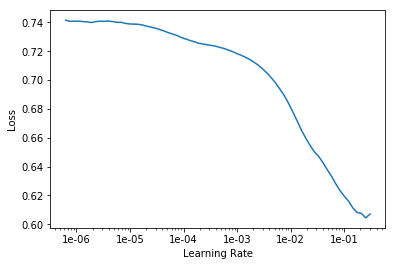

In [0]:
learn2.lr_find()
learn2.recorder.plot()

In [0]:
learn_submission.callback_fns = []

In [0]:
y =learn_submission.get_preds();y

[tensor([[0.7493, 0.2507],
         [0.9568, 0.0432],
         [0.5571, 0.4429],
         ...,
         [0.8552, 0.1448],
         [0.7912, 0.2088],
         [0.7638, 0.2362]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [0]:
interp = ClassificationInterpretation.from_learner(learn2)

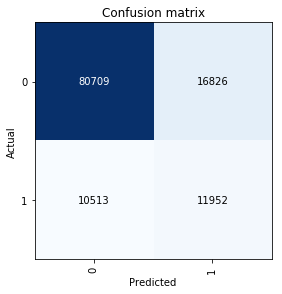

In [0]:
interp.plot_confusion_matrix()

In [0]:
preds = learn_submission.validate();preds

[0.5372261, tensor(0.7734), tensor(0.7722)]

In [0]:
preds = learn_submission.get_preds(ds_type=DatasetType.Test)
y = to_np(y[0])[:,1]
output = pd.read_csv('./input/sample_submission.csv')
output['target']= y
output.to_csv('submission.csv',index=False)